In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline, BertTokenizer, BertModel, TFBertModel, AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
from transformers import AdamW

In [126]:
train = pd.read_csv('train.tsv', sep = '\t')
dev = pd.read_csv('dev.tsv', sep = '\t')
test = pd.read_csv('test.tsv', sep = '\t')

In [127]:
train.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,


In [128]:
train['claim'][1]

'Annual Mammograms May Have More False-Positives'

In [129]:
train['explanation'][1]

'This article reports on the results of a study of nearly 170,000 women who had screening mammograms beginning between age 40-59. The study found that over ten years of screening mammograms, over half of the women will experience a false-positive recall for additional mammography. In addition, 7%-9% of the women will have a biopsy for a suspicious lump which is not cancerous. Both of those percentages decrease if the woman is screened every other year rather than every year. Even with biennial mammography, 41% of women will experience a\xa0recall over 10 years of mammography. The study’s Principal Investigator emphasized that “in most cases, a recall doesn’t mean you have cancer.”\xa0 She hoped this knowledge would reduce the anxiety of women who are recalled. The story never explained the size of the decrease in the number of false positives between annual (61.3%) and biennial screening (41.6%). Our first two reviewers were a researcher who specializes in health decisions and a breast

In [130]:
train['main_text'][1]

'While the financial costs of screening mammography & false-positive recalls & biopsies were not included in the study, readers would benefit from being reminded that recall mammography & biopsies increase patient financial costs. This article leads with valuable information for all women over age 40 by stating “Getting screening mammograms every two years instead of annually reduces the chance of a false alarm, a new study shows.”\xa0 Unfortunately the writer doesn’t quantify or elaborate adequately on that reduction. Instead, the writer later focuses on how women undergoing screening mammography shouldn’t be anxious if they experience a recall because over half of women who have screening mammograms for 10 years will be recalled. Readers would have been better served if the writer had emphasized the significant reduction in both recall mammograms & false-positive biopsies in women who are screened every two years rather than annually. Part of the continuing controversy\xa0over screen

In [131]:
# Take only the 4 important labels

labels = ['true', 'false', 'mixture', 'unproven']
train = train[train.label.isin(labels)]
dev = dev[dev.label.isin(labels)]
test = test[test.label.isin(labels)]

In [132]:
cols = ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers',
       'main_text', 'sources', 'label', 'subjects']

df = train[cols].append(dev[cols]).append(test[cols])

In [133]:
df.isnull().sum()

claim_id             0
claim                0
date_published    2398
explanation          0
fact_checkers        0
main_text            0
sources              1
label                0
subjects             0
dtype: int64

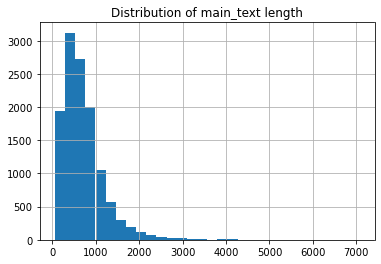

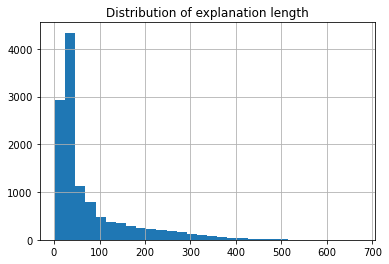

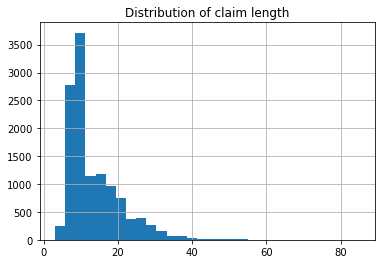

In [134]:
# Get lengths of claims, explanation, and main text to see how much to pad them
seq_len_maintext = [len(i.split()) for i in df.main_text]
seq_len_claim = [len(i.split()) for i in df.claim]
seq_len_explanation = [len(i.split()) for i in df.explanation]

pd.Series(seq_len_maintext).hist(bins = 30)
plt.title('Distribution of main_text length')
plt.show()
pd.Series(seq_len_explanation).hist(bins = 30)
plt.title('Distribution of explanation length')
plt.show()
pd.Series(seq_len_claim).hist(bins = 30)
plt.title('Distribution of claim length')
plt.show()

In [135]:
# Create a new column, appending claim, explanation and main text

train['input_text'] = train.claim + ' ' + train.explanation + ' ' + train.main_text
dev['input_text'] = dev.claim + ' ' + dev.explanation + ' ' + dev.main_text
test['input_text'] = test.claim + ' ' + test.explanation + ' ' + test.main_text
df['input_text'] = df.claim + ' ' + df.explanation + ' ' + df.main_text

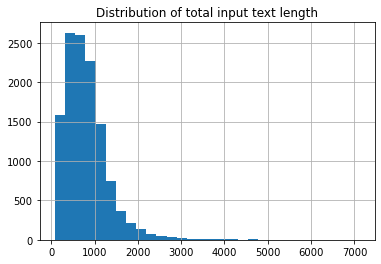

In [136]:
seq_len_input_text = [len(i.split()) for i in df.input_text]

pd.Series(seq_len_input_text).hist(bins = 30)
plt.title('Distribution of total input text length')
plt.show()

In [137]:
# We can fix a max length of 512 and if less than that, add padding. Not setting to higher due to model constraints and
# possible errors in indexing

In [138]:
unmasker = pipeline('fill-mask', model='bert-base-cased')
unmasker("Hello I'm a [MASK] model.")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.09019182622432709,
  'sequence': "Hello I'm a fashion model.",
  'token': 4633,
  'token_str': 'fashion'},
 {'score': 0.06350025534629822,
  'sequence': "Hello I'm a new model.",
  'token': 1207,
  'token_str': 'new'},
 {'score': 0.06228208169341087,
  'sequence': "Hello I'm a male model.",
  'token': 2581,
  'token_str': 'male'},
 {'score': 0.044172950088977814,
  'sequence': "Hello I'm a professional model.",
  'token': 1848,
  'token_str': 'professional'},
 {'score': 0.03326145559549332,
  'sequence': "Hello I'm a super model.",
  'token': 7688,
  'token_str': 'super'}]

In [139]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = AutoModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [140]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train.input_text.tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation=True)
print('Done')

# tokenize and encode sequences in the dev set
tokens_dev = tokenizer.batch_encode_plus(
    dev.input_text.tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation=True)
print('Done')

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test.input_text.tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation=True)

Done
Done


In [141]:
# One-hot encode labels

le = LabelEncoder()
train_labels = le.fit_transform(train.label.tolist())
dev_labels = le.transform(dev.label.tolist())
test_labels = le.transform(test.label.tolist())

In [142]:
## convert lists to torch tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = nn.functional.one_hot(torch.Tensor(train_labels).to(torch.int64), num_classes = 4)

dev_seq = torch.tensor(tokens_dev['input_ids'])
dev_mask = torch.tensor(tokens_dev['attention_mask'])
dev_y = nn.functional.one_hot(torch.Tensor(dev_labels).to(torch.int64), num_classes = 4)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = nn.functional.one_hot(torch.Tensor(test_labels).to(torch.int64), num_classes = 4)

In [143]:
# Split train and dev data into batches

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler = dev_sampler, batch_size = batch_size)

In [144]:
# Fix bert model architecture - no fine-tuning
for param in model.parameters():
    param.requires_grad = False

In [145]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        # Add dropout
        self.dropout = nn.Dropout(0.1)
        # ReLU activation
        self.relu =  nn.ReLU()
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(768,512)
        # Final layer
        self.fc2 = nn.Linear(512,4)
        
        # Softmax for multiclass likelihoods
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [146]:
# pass the pre-trained BERT to our define architecture
transfer_model = BERT_Arch(model)

In [ ]:
# Define optimizer
